# News spreading on youtube from US Channels


## Table of Contents
* [1 Preprocessing and data filtering](#filter_data)
    * [1.1 Filter for Category 'News & Politics'](#filter_data-category)
    * [1.2 Filter for Active Channels](#filter_data-active)
    * [1.3 Get country of channel](#filter_data-country)
    * [1.4 Get if channel is english-speaking](#filter_data-english)
    * [1.5 Filter for language and country and save final data](#filter_data-save)
        * [1.5.1 Filtering relevant comments](#filter_data-comments)
* [2 How US News report on different events](#status_quo)
    * [2.1 Get relevant videos per event](#status_quo-videos_per_event)
    * [2.2 Extract video and channel features](#status_quo-features)
    * [2.3 Results and Comparison between Events](#status_quo-results)
* [3 How does the public response to events](#public_response)
    * [3.1 Compute Public Response Metrics](#public_response-metrics)
    * [3.2 Compute Correlation between Video Features and Response Metrics](#public_response-correlation)
    * [3.3 Compute F- and T-tests](#public_response-ttest)
* [4 Conclusion](#conclusion)

**Global imports**

In [4]:
import pandas as pd
import numpy as np
import polars as pl
from matplotlib import pyplot as plt
from src.scripts import filters
from datetime import datetime
import matplotlib.dates as mdates
import importlib

from src.utils import keywords
importlib.reload(keywords)
# from src.utils import analysis_tools

<module 'src.utils.keywords' from 'c:\\Users\\leoga\\Documents\\_Schuel\\MA3\\ADA\\project\\ada-2024-project-lil0mohammadali\\src\\utils\\keywords.py'>

**Path definitions**

In [5]:
path_df_channels_en = 'data/df_channels_en.tsv'
# TODO: not used yet path_df_channels_filtered = 'data/filtered_df_channels_en.csv'

path_df_timeseries = 'data/df_timeseries_en.tsv'

path_yt_metadata_feather = 'data/yt_metadata_helper.feather'
path_yt_metadata_feather_filtered = 'data/filtered_yt_metadata_helper.feather.csv'

path_yt_metadata = 'data/yt_metadata_en.jsonl'
path_yt_metadata_filtered = 'data/filtered_yt_metadata.csv'

path_final_channels = 'data/final_channels.csv'
path_final_timeseries = 'data/final_timeseries.csv'
path_final_yt_metadata_feather = 'data/final_yt_metadata_helper.csv'
path_final_yt_metadata = 'data/final_yt_metadata.csv'

## 2 How US News report on different events <a class="anchor" id="status_quo"></a>

### 2.1 Get relevant videos per event <a class="anchor" id="status_quo-videos_per_event"></a>

TODO: USING JADS CODE AND PLOTS

In [6]:
# load data in such a way to avoid errors
metadata = pl.read_csv(path_final_yt_metadata,  schema_overrides={
                                "dislike_count": pl.Float64,
                                "like_count": pl.Float64},
                                ignore_errors = True)

In [7]:
# counting erroneous like/dislike and date entries
keywords.summarize_outliers(metadata)

Total number of videos: 2,548,064
Date Outlier Count: 164,271
Like/Dislike Outlier Count (null elements): 223,686


In [8]:
# removing rows there the like or dislike entry is null, or where the date entry is erroneous (like "17")
metadata = keywords.filtering_bad_rows(metadata)

Original metadata shape: (2,548,064, 12)
New metadata shape: (2,324,376, 12)


In [9]:
keywords.summarize_outliers(metadata)

Total number of videos: 2,324,376
Date Outlier Count: 0
Like/Dislike Outlier Count (null elements): 0


In [10]:
## removing the hour time from the upload_date since it's always 00:00:00
metadata = keywords.remove_hour(metadata)

In [11]:
list(metadata['title'].sample(20))

['Not clear what can be done to turn around Harley sales decline, says analyst',
 'Mattress Mack makes good on Astros bet',
 "Celebrating Washington's national parks",
 'Stadium Protesters Had Tickets To Vikings Game, Concealed Gear',
 'Armed Masked Men Intimidate Black Lives Matter Protests',
 "Ride of the Week: Tony Tinoco's '64 Chevy Impala SS",
 'Wintry weather leads to icy roads, crashes',
 'FHP investigating deadly pedestrian hit-and-run | Digital Short',
 'News Headlines | 2:00pm | 16 July 2019 |  City 42',
 'Hundreds run through downtown Cleveland in their underwear for charity',
 "Police officer saves woman's life with CPR",
 'Proposed Carmichael Parks Merger Draws Ire Of Community',
 'Jury seated for trial of woman in Saraland Waffle House video',
 'President Trump: This Was A Successful Mission -The Trump Doctrine - Hannity',
 'Charges filed after toddler tumbles out of car in Mankato',
 'Explainer: The Internet of Things',
 'BREAKING: "China Stock Market Crashes" Dow Jones 

In [12]:
metadata

categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
str,str,str,str,f64,str,i64,f64,str,str,date,str
"""People & Blogs""","""UCzF4Ryn8TKn64md77gS5Q5Q""","""2019-11-04 21:11:23.560250""","""There has been a lot of emotio…",0.0,"""BFlU3b68aNs""",60,3.0,"""politics,news""","""Online reaction swift after Ge…",2019-03-29,"""401 """
"""People & Blogs""","""UCzF4Ryn8TKn64md77gS5Q5Q""","""2019-11-04 21:11:25.961967""","""The measure outlaws abortions …",2.0,"""rbBK6syU-fY""",259,31.0,"""politics,news""","""Georgia House passes 'heartbea…",2019-03-29,"""916 """
"""People & Blogs""","""UCzF4Ryn8TKn64md77gS5Q5Q""","""2019-11-04 21:11:28.406280""","""The bear has been spotted by s…",0.0,"""u5pwbK0_E0c""",769,7.0,"""animals,local,news,life""","""'Buckhead Bear' spotted rummag…",2019-03-29,"""116 """
"""People & Blogs""","""UCzF4Ryn8TKn64md77gS5Q5Q""","""2019-11-04 21:11:30.764228""","""The former X-Factor contestant…",1.0,"""qUPXnZseiTc""",167,34.0,"""the-a-scene,entertainment,tele…","""Behind the sound: Simone Torre…",2019-03-29,"""2521 """
"""People & Blogs""","""UCzF4Ryn8TKn64md77gS5Q5Q""","""2019-11-04 21:11:24.684348""","""A yummy springtime spread with…",0.0,"""1JvFjfzlbE8""",359,1.0,"""atlanta-and-company,entertainm…","""Springtime Spread with Lara Ly…",2019-03-29,"""41 """
…,…,…,…,…,…,…,…,…,…,…,…
"""News & Politics""","""UCry2gCVdntv6r661sKUiKXw""","""2019-11-01 21:05:41.255325""","""A new documentary film explore…",0.0,"""XU-phrdiMYQ""",199,0.0,"""WCCO Mid-Morning,reynold phili…","""New Documentary Focused On Min…",2017-06-22,"""1054 """
"""News & Politics""","""UCry2gCVdntv6r661sKUiKXw""","""2019-11-01 21:05:41.963190""","""This Saturday, there's a big e…",0.0,"""cK19B-6ukFs""",189,0.0,"""WCCO Mid-Morning,heartbeat 500…","""Race for Children's: HeartBeat…",2017-06-22,"""21 """
"""News & Politics""","""UCry2gCVdntv6r661sKUiKXw""","""2019-11-01 21:05:42.668689""","""A group of men in Europe are p…",0.0,"""CNrH1AA6wpo""",63,2.0,"""WCCO Mid-Morning,skirts,protes…","""Viewers Weigh In On Men Protes…",2017-06-22,"""74 """


Event: Kosovo–Serbia Tensions and Border Clashes (2018-2019)
Related videos found: 407


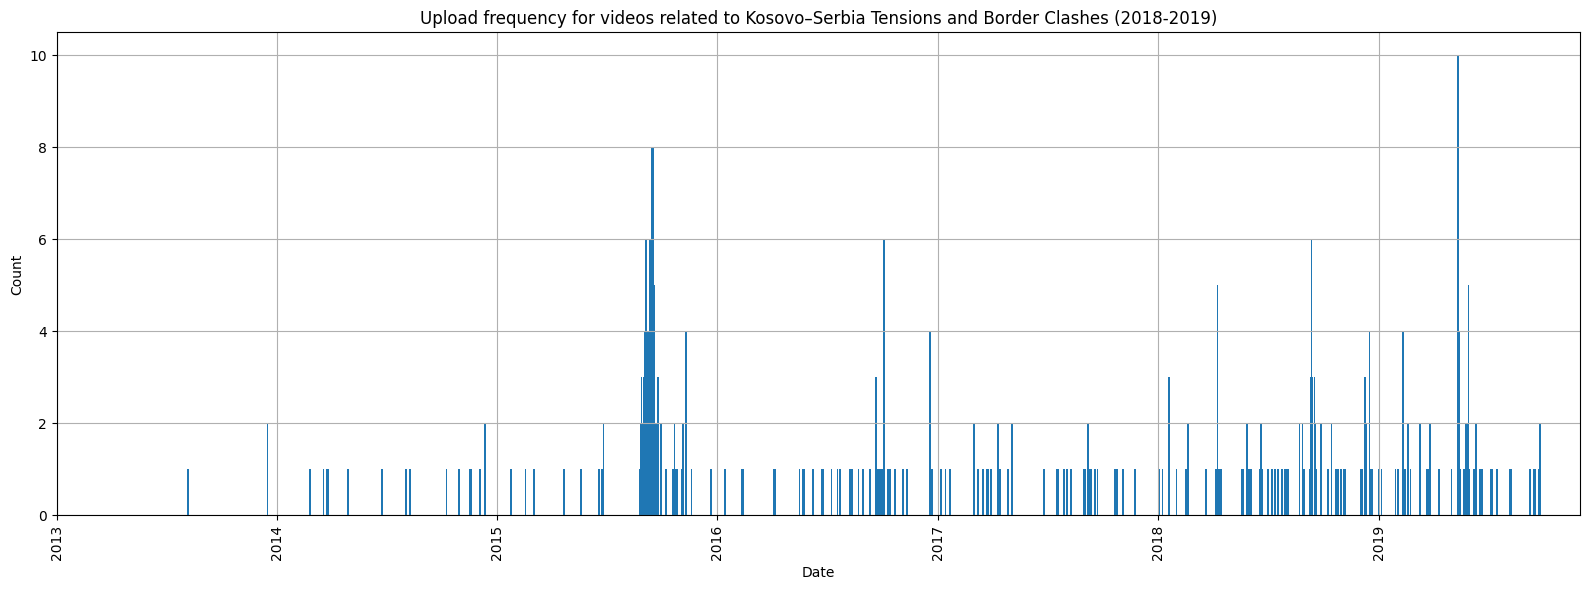

In [82]:
# plot the evolution of upload frequency for each event
importlib.reload(keywords)

index = 25    # 0-N List is found in keywords.py

"""
# all_plots = True to plot for all the events, disregards chosen index. Else plot for the even corresponding to chosen index
# grouping_mode: "daily", "weekly", "monthly"

 """
start_date = datetime(2016, 1, 1)  
start_date = False

something = keywords.plot_update_freq_v4(index, metadata, all_plots = False, grouping_mode = "daily", event_type = "environment")     # function that can take individual terms (with or) and groups of terms (with and)

In [78]:
list(something['title'])

["Iyanla Vanzant details new season of 'Fix My Life'",
 "Iyanla Vanzant is back with an all new season of 'Iyanla Fix My Life'",
 'Terrell Owens suing Atlanta company for $1M, saying memorabilia was unlawfully stole and sold',
 'Tropical Storm Jerry becomes 10th named storm of season',
 'Toppled trees bring destruction as far inland as Charlotte, North Carolina',
 'Attorney Gerald Griggs responds to woman tased, punched by Atlanta Police over warrant',
 'The Reveal | A full show of investigative reports Ep. 14',
 'Tracking the Tropics: Update on Barry',
 'Hartsfield-Jackson feeling the strain of Barry',
 'Tracking Barry after landfall',
 'President Trump cancels trip to Denmark after Greenland rejection',
 'Buses transport North Carolina residents farther inland ahead of Dorian',
 'Hurricane warning is in effect for coastal waters, a tropical storm warning is in effect inland',
 "Gerard Butler spotted around Macon during 'Greenland' filming",
 'Teens sentenced for planning attack again

Event: Portugal Wildfires (2017)
Related videos found: 54


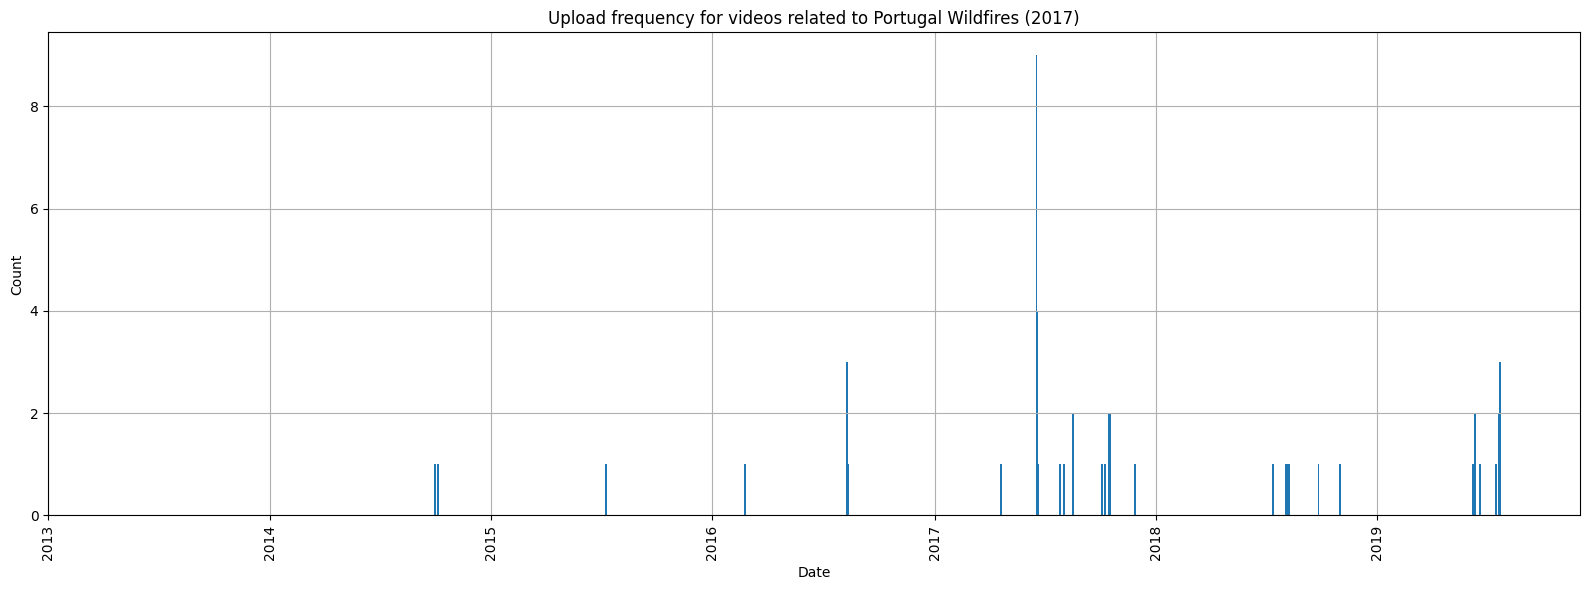

categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
str,str,str,str,f64,str,i64,f64,str,str,date,str
"""News & Politics""","""UChirEOpgFCupRAk5etXqPaA""","""2019-11-11 19:14:11.966700""","""France’s annual Bastille Day c…",2.0,"""2TTshNgo8Rg""",21,82.0,"""bastille day,emmanuel macron,b…","""Flyboard Wows at Paris's Basti…",2019-07-15,"""39257 """
"""News & Politics""","""UCeY0bbntWzzVIaj2z3QigXg""","""2019-11-01 02:49:03.014931""","""At least 41 people have been k…",8.0,"""LZbpzJCJTrU""",99,37.0,"""nbc news,nbc,news,news channel…","""Deadly Wildfires Kill 41 In Sp…",2017-10-17,"""4640 """
"""News & Politics""","""UCeY0bbntWzzVIaj2z3QigXg""","""2019-11-01 02:49:03.496489""","""Portuguese officials blame ars…",1.0,"""i_TnJ9eu8yk""",70,1.0,"""nbc news,nbc,news,news channel…","""Deadly Wildfires Kill At Least…",2017-10-17,"""346 """
"""News & Politics""","""UCeY0bbntWzzVIaj2z3QigXg""","""2019-11-01 02:49:10.518242""","""A rare fire whirl, sometimes c…",175.0,"""y0V2ll9d_xY""",51,551.0,"""nbc news,nbc,news,news channel…","""‘Fire Devil’ Caught On Camera …",2017-10-09,"""142661 """
"""News & Politics""","""UCeY0bbntWzzVIaj2z3QigXg""","""2019-11-01 02:52:04.353302""","""At least three people are dead…",3.0,"""QZLI8aH6O2o""",66,5.0,"""NBC News,NBC,news,video,Breaki…","""Deadly Wildfire Rages Across P…",2016-08-10,"""1776 """
…,…,…,…,…,…,…,…,…,…,…,…
"""People & Blogs""","""UC4SH8rh0OjYV3zwqnIfqNbA""","""2019-11-01 15:02:32.146710""","""After 3 West Bank Arabs attack…",20.0,"""7iP2TRNZeqs""",340,410.0,"""news,bible prophecy,Jesus Save…","""PROPHECY Alert: ""Jerusalem Cra…",2017-06-18,"""12035 """
"""People & Blogs""","""UC4SH8rh0OjYV3zwqnIfqNbA""","""2019-11-01 15:02:32.737788""","""A powerful 5.0 Quake hits Icel…",182.0,"""ya-efbnkcPk""",485,553.0,"""news,bible prophecy,Jesus Save…","""Breaking: ""Quake Causes Landsl…",2017-06-18,"""46319 """
"""People & Blogs""","""UC4SH8rh0OjYV3zwqnIfqNbA""","""2019-11-01 15:02:38.446088""","""Apocalyptic Warnings of a majo…",27.0,"""n5duj0hgqCI""",219,440.0,"""news,bible prophecy,Jesus Save…","""""Apocalyptic Warnings Hurrican…",2017-06-18,"""13579 """


In [18]:
# plot the evolution of upload frequency for each event

#### BEFORE KEYWORD IMPROVEMENTS #####

importlib.reload(keywords)

index = 10     # 0-N List is found in keywords.py

"""
# all_plots = True to plot for all the events, disregards chosen index. Else plot for the even corresponding to chosen index
# grouping_mode: "daily", "weekly", "monthly"

 """

keywords.plot_update_freq_v4(index, metadata, all_plots = False, grouping_mode = "daily", event_type = "environment")     # function that can take individual terms (with or) and groups of terms (with and)

Event: Mosul Offensive (2016-2017) - Iraq
Related videos found: 990
------------
Event: Battle of Kobani (2014-2015) - Syria
Related videos found: 81
------------
Event: Battle of Raqqa (June - October 2017) - Syria
Related videos found: 312
------------
Event: Hudaydah Offensive (2018) - Yemen
Related videos found: 533
------------
Event: Kunduz City Attack (2015) - Afghanistan
Related videos found: 63
------------
Event: Battle of Sirte (2016) - Libya
Related videos found: 49
------------
Event: India-Pakistan Conflict / Kashmir Conflict (Pulwama and Balakot Airstrikes) (February 2019)
Related videos found: 105
------------
Event: Syrian Civil War (Aleppo Offensive (2016), Idlib Campaign (2019))
Related videos found: 851
------------
Event: Yemeni Civil War (2015-2019) - West Asia
Related videos found: 2,146
------------
Event: Nagorno-Karabakh Conflicts (Clashes (2016)) - Armenia-Azerbaijan
Related videos found: 17
------------
Event: Crimea Annexation and Conflict in Eastern Ukrain

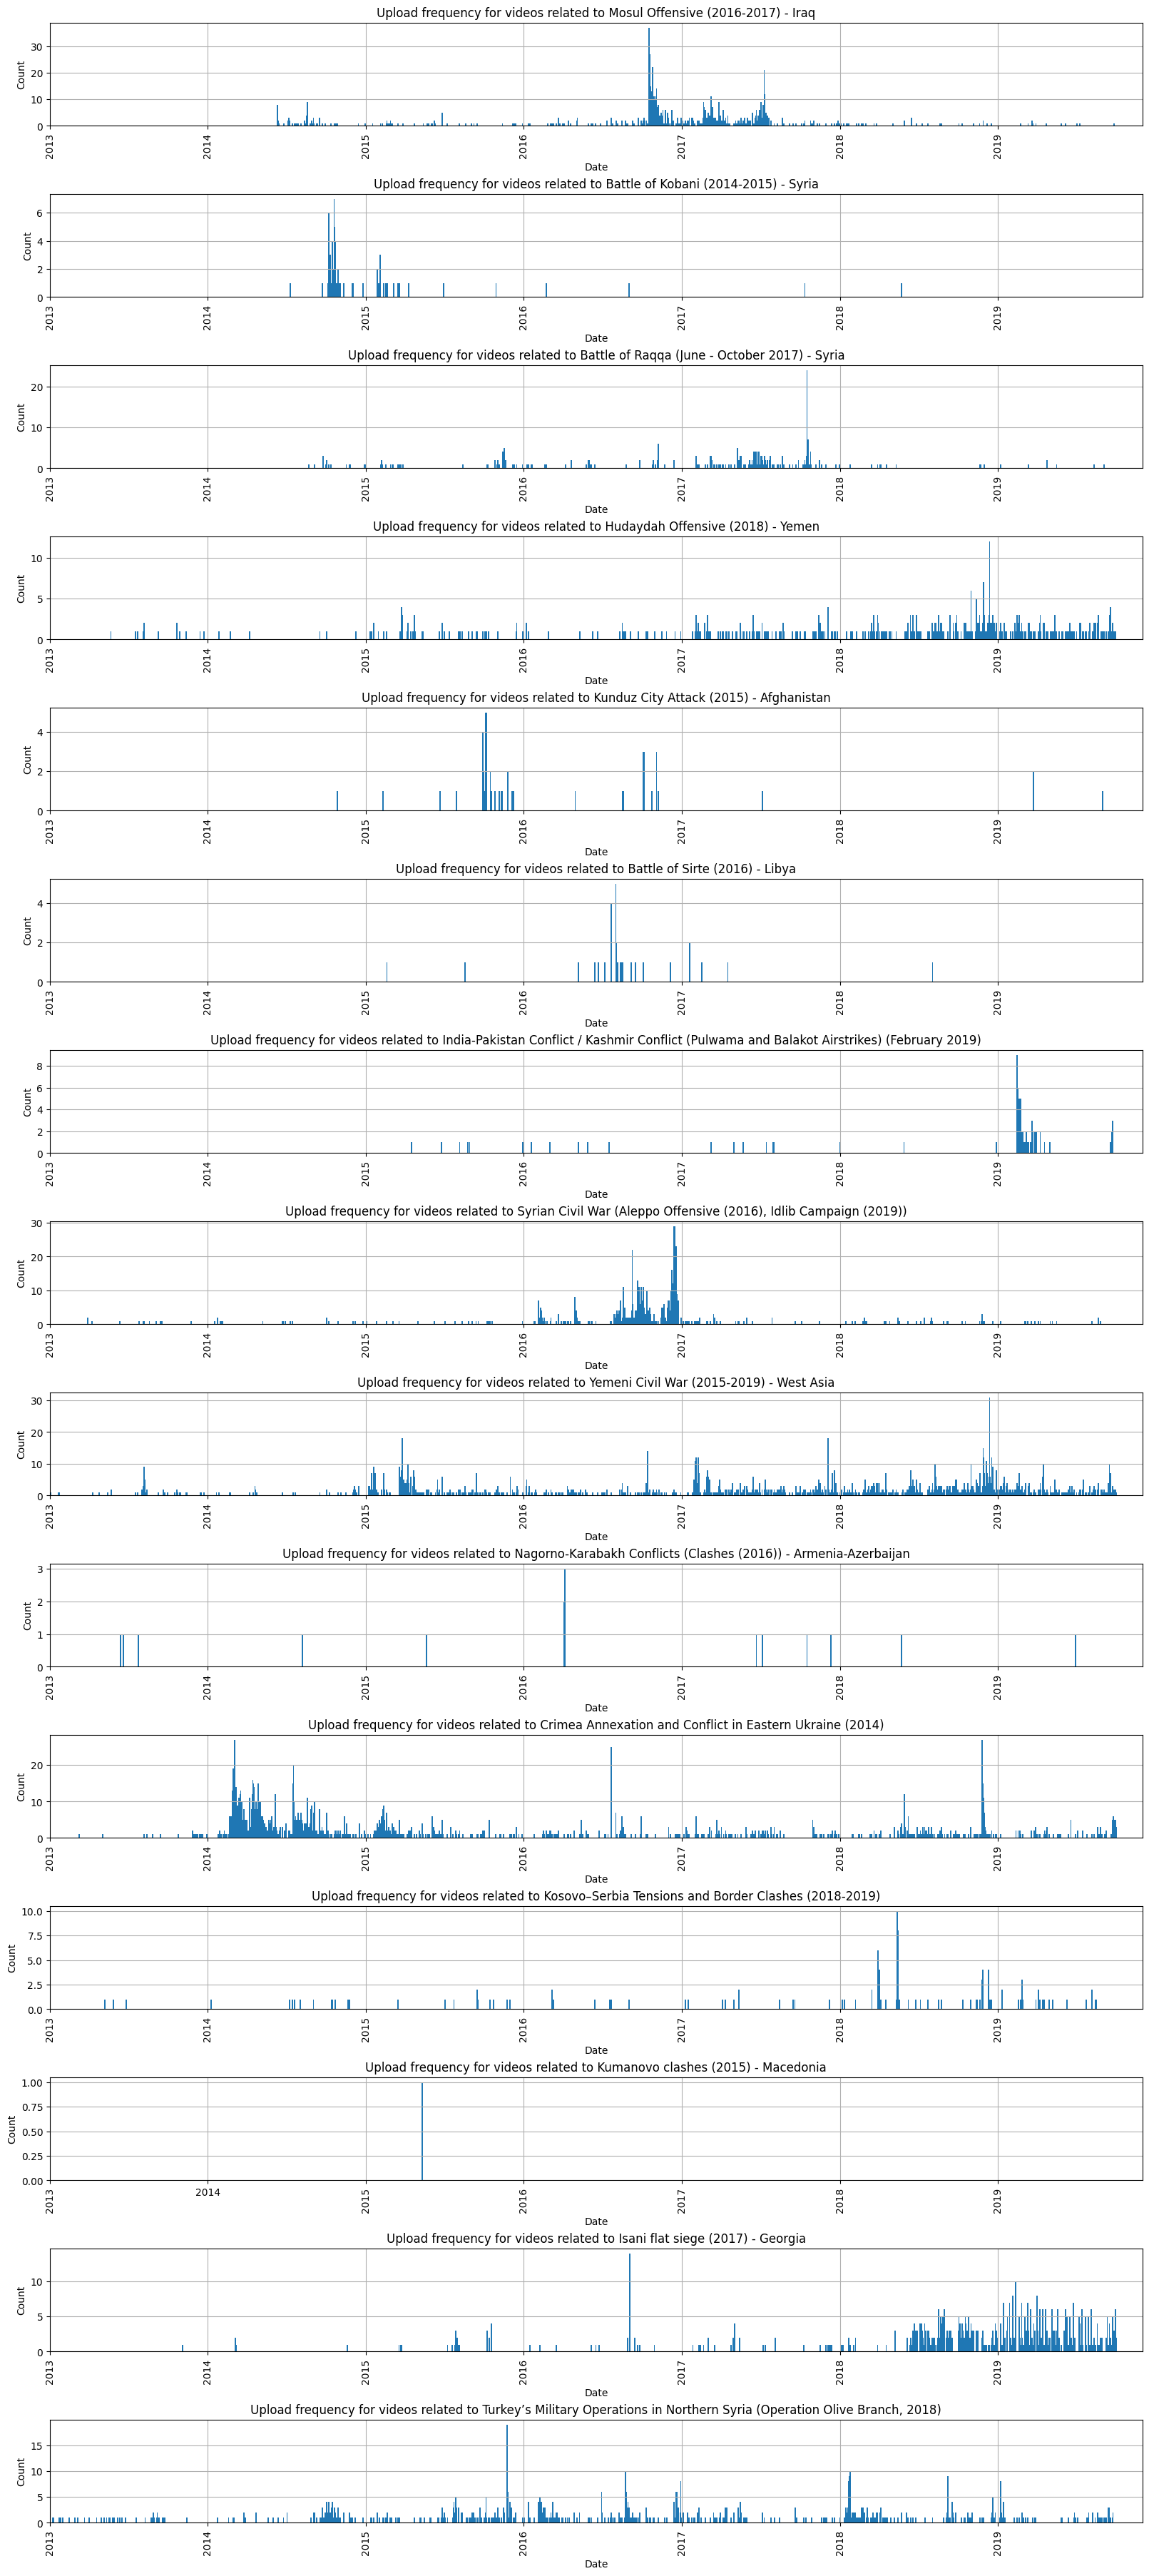

In [16]:
# plot the evolution of upload frequency for each event
importlib.reload(keywords)

index = 0      # 0-N List is found in keywords.py

"""
# all_plots = True to plot for all the events, disregards chosen index. Else plot for the even corresponding to chosen index
# grouping_mode: "daily", "weekly", "monthly"

 """

keywords.plot_update_freq_v2(index, metadata, all_plots = True, grouping_mode = "daily", event_type = "conflict")     # function that can take individual terms (with or) and groups of terms (with and)